In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
import xgboost as xgb

from sklearn.preprocessing import PowerTransformer


import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [65]:
df = pd.read_csv("trainable_df.csv")

In [66]:
df

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Previous_Claims_MEDIAN_Premium_Amount,SCALER_Previous_Claims_MEAN_Premium_Amount,SCALER_Previous_Claims,SCALER_Previous_Claims_STD_Premium_Amount,SCALER_Previous_Claims_MAX_Premium_Amount,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Number_of_Dependents_MEAN_Premium_Amount,SCALER_Number_of_Dependents_MEDIAN_Premium_Amount,SCALER_Insurance_Duration_MEAN_Premium_Amount,SCALER_Insurance_Duration_MEDIAN_Premium_Amount,SCALER_Number_of_Dependents_STD_Premium_Amount,SCALER_Occupation_MEAN_Premium_Amount,SCALER_Occupation_MAX_Premium_Amount,SCALER_Occupation_MEDIAN_Premium_Amount,SCALER_Previous_Claims_MIN_Premium_Amount,SCALER_Insurance_Duration_MAX_Premium_Amount,SCALER_Age,SCALER_Insurance_Duration_STD_Premium_Amount,SCALER_Number_of_Dependents,SCALER_Occupation_STD_Premium_Amount,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single,Premium Amount
0,-0.389078,-0.974138,28.5,24.535366,1.0,4.862885,-3.0,-0.118056,1.2,0.570401,0.571429,-0.739699,0.00,0.726836,-0.683947,0.4,-0.333333,0.0,0.222222,-0.956522,-2.155882,-0.5,0.000000,0.467738,0.702758,0.333333,0.7,-0.5,1.0,0.0,1.0,0.0,2869.0
1,0.201474,0.413793,-1.0,0.000000,0.0,0.000000,0.0,-0.515810,0.0,0.000000,0.000000,0.458999,1.50,-0.273164,-0.683947,0.4,-0.333333,0.0,0.333333,-0.086957,-0.783022,0.5,0.000000,-0.266204,0.201396,0.333333,0.5,0.0,1.0,0.0,0.0,0.0,1483.0
2,0.035577,-0.185345,-1.0,0.000000,0.0,0.000000,0.0,1.272794,0.6,0.000000,0.000000,-0.557755,0.00,-0.273164,-0.683947,0.4,-0.333333,0.0,0.333333,-0.782609,0.000000,0.5,0.000000,0.933425,0.398426,0.333333,0.6,0.5,1.0,0.0,0.0,0.0,567.0
3,3.209720,-0.995690,-1.0,0.000000,0.0,0.000000,0.0,-0.777900,0.0,0.575111,0.000000,-1.483870,-2.75,0.802161,-0.683947,0.4,-0.333333,0.0,-0.666667,-0.869565,-0.133238,0.0,0.000000,-0.266449,-0.996152,0.666667,0.9,-0.5,1.0,0.0,1.0,0.0,765.0
4,0.419167,0.000000,0.0,-1.000000,-1.0,-1.000000,1.0,-0.243831,1.2,0.570401,0.571429,0.032506,0.00,0.726836,-0.683947,0.4,-0.333333,0.0,-0.333333,-0.869565,0.216978,-0.5,0.000000,-0.998974,-0.195156,-0.333333,-0.1,-0.5,1.0,0.0,0.0,1.0,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,0.395440,-1.245690,-1.0,0.000000,0.0,0.000000,0.0,-0.576421,0.2,0.570401,0.571429,0.458999,1.50,0.726836,0.316053,-0.6,0.666667,0.0,0.333333,0.391304,-0.783022,-0.5,-0.127755,-0.465795,-0.196160,-0.333333,-0.2,0.0,0.0,0.0,1.0,0.0,NaN
1999996,1.342334,-0.629310,28.5,24.535366,1.0,4.862885,-3.0,-0.935914,-0.6,-0.429599,-1.000000,0.458999,1.50,-0.651740,-0.683947,0.4,-0.333333,0.0,0.333333,0.652174,-0.783022,-1.0,0.000000,0.799267,-0.999622,0.333333,0.4,0.5,1.0,0.0,0.0,1.0,NaN
1999997,0.297038,0.715517,28.5,24.535366,1.0,4.862885,-3.0,-1.021314,0.6,-0.429599,-1.000000,0.000000,0.25,-0.651740,0.316053,-0.6,0.666667,0.0,0.555556,-0.652174,0.280920,-1.0,-0.127755,0.933117,0.000563,-1.000000,-1.0,-0.5,0.0,0.0,0.0,1.0,NaN
1999998,0.583263,-0.564655,28.5,24.535366,1.0,4.862885,-3.0,-0.495013,-0.2,0.000000,0.000000,0.277595,1.25,-0.273164,-0.683947,0.4,-0.333333,0.0,-0.666667,-0.304348,0.159496,0.5,0.000000,-0.465919,0.702337,0.000000,0.1,0.0,1.0,0.0,0.0,1.0,NaN


#
---
#

# Just Checking!

In [67]:
def return_splits(ddf, feature_name, target_name):
    return [ddf[ddf[feature_name] == i][target_name] for i in ddf[feature_name].unique()]

def give_stats_analysis(df, target_column_name):
    ddf = df.copy()
    ddf = ddf.dropna()

    features = []
    tests = []
    stats = []
    pvals = []
    verdict = []
    count = 0

    target = ddf[target_column_name]
    for i in ddf.columns:
        features.append(i)
        feature = ddf[i]
        
        if (feature.dtype == "O" and (target.dtype == "float" or target.dtype == "int")) or (target.dtype == "O" and (feature.dtype == "float" or feature.dtype == "int")):
            stat, pval, *_ = kruskal(*return_splits(ddf, feature.name, target.name))
            tests.append("Kruskal-Wallis")
            stats.append(stat)
            pvals.append(pval)
            
        
        elif (feature.dtype == "float" or feature.dtype == "int") and (target.dtype == "float" or target.dtype == "int"):
            stat, pval, *_ = spearmanr(feature, target)
            tests.append("SpearmanR")
            stats.append(stat)
            pvals.append(pval)

        elif feature.dtype == "O" and target.dtype == "O":
            stat, pval, *_ = chi2_contingency(pd.crosstab(feature, target))
            tests.append("Chi-Square")
            stats.append(stat)
            pvals.append(pval)
        
        else:
            tests.append(np.nan)
            stats.append(np.nan)
            pvals.append(np.nan)
        
        if pval <= 0.05:
            verdict.append("There is Relationship")
        else:
            verdict.append("There is NO Relationship")

        print(f"{feature.name} ■■■ {target_column_name}".ljust(50, "-")+"✅")
    
    return pd.DataFrame({
        "Feature" : features,
        "Target" : [target_column_name]*ddf.shape[1],
        "Statistic Test" : tests,
        "Test Statistic" : stats,
        "P-Value" : pvals,
        "Verdict" : verdict
    }).sort_values(by="P-Value")

In [68]:
give_stats_analysis(df, "Premium Amount")

SCALER_Annual_Income ■■■ Premium Amount-----------✅
SCALER_Credit_Score ■■■ Premium Amount------------✅
SCALER_Previous_Claims_MEDIAN_Premium_Amount ■■■ Premium Amount✅
SCALER_Previous_Claims_MEAN_Premium_Amount ■■■ Premium Amount✅
SCALER_Previous_Claims ■■■ Premium Amount---------✅
SCALER_Previous_Claims_STD_Premium_Amount ■■■ Premium Amount✅
SCALER_Previous_Claims_MAX_Premium_Amount ■■■ Premium Amount✅
SCALER_Health_Score ■■■ Premium Amount------------✅
SCALER_Policy_Start_Date_-_Month ■■■ Premium Amount✅
SCALER_Number_of_Dependents_MEAN_Premium_Amount ■■■ Premium Amount✅
SCALER_Number_of_Dependents_MEDIAN_Premium_Amount ■■■ Premium Amount✅
SCALER_Insurance_Duration_MEAN_Premium_Amount ■■■ Premium Amount✅
SCALER_Insurance_Duration_MEDIAN_Premium_Amount ■■■ Premium Amount✅
SCALER_Number_of_Dependents_STD_Premium_Amount ■■■ Premium Amount✅
SCALER_Occupation_MEAN_Premium_Amount ■■■ Premium Amount✅
SCALER_Occupation_MAX_Premium_Amount ■■■ Premium Amount✅
SCALER_Occupation_MEDIAN_Premium_

,Feature,Target,Statistic Test,Test Statistic,P-Value,Verdict
0,SCALER_Annual_Income,Premium Amount,SpearmanR,-0.060743,0.000000e+00,There is Relationship
1,SCALER_Credit_Score,Premium Amount,SpearmanR,-0.037141,0.000000e+00,There is Relationship
32,Premium Amount,Premium Amount,SpearmanR,1.000000,0.000000e+00,There is Relationship
2,SCALER_Previous_Claims_MEDIAN_Premium_Amount,Premium Amount,SpearmanR,0.032126,1.918797e-271,There is Relationship
3,SCALER_Previous_Claims_MEAN_Premium_Amount,Premium Amount,SpearmanR,0.031064,6.364897e-254,There is Relationship
4,SCALER_Previous_Claims,Premium Amount,SpearmanR,0.031063,6.484953e-254,There is Relationship
5,SCALER_Previous_Claims_STD_Premium_Amount,Premium Amount,SpearmanR,0.031063,6.486331e-254,There is Relationship
6,SCALER_Previous_Claims_MAX_Premium_Amount,Premium Amount,SpearmanR,-0.031059,7.464753e-254,There is Relationship
7,SCALER_Health_Score,Premium Amount,SpearmanR,0.016407,3.101445e-72,There is Relationship
25,SCALER_ENCODED_Policy_Start_Date_-_Year,Premium Amount,SpearmanR,-0.010257,2.694388e-29,There is Relationship


#
---
#

<Axes: xlabel='Premium Amount', ylabel='SCALER_Credit_Score'>

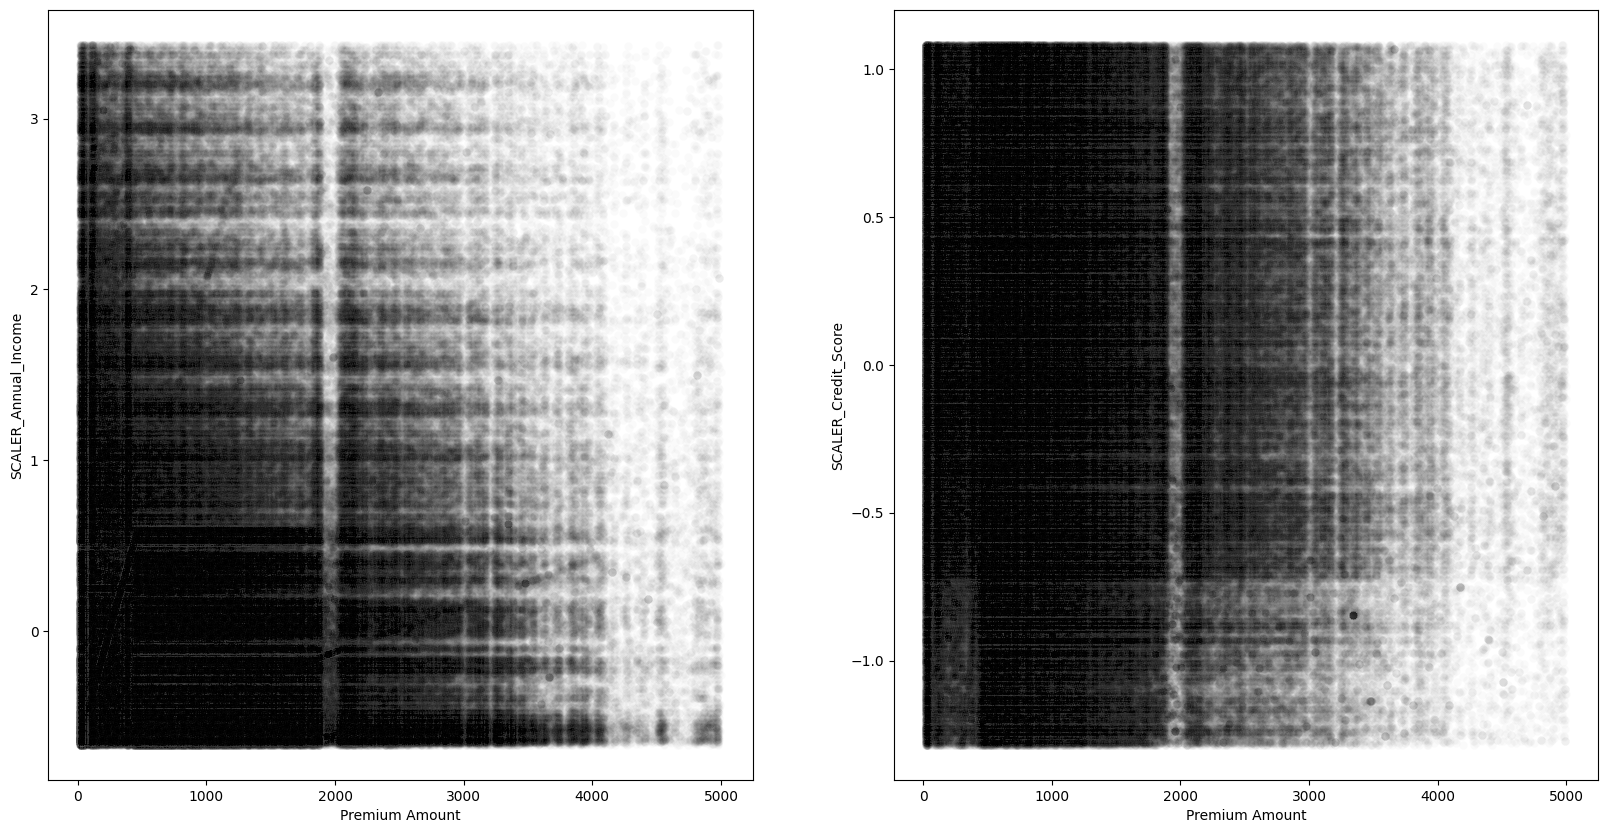

In [69]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.scatterplot(x=df["Premium Amount"], y=df["SCALER_Annual_Income"], color="black", alpha = 0.02)

plt.subplot(1, 2, 2)
sns.scatterplot(x=df["Premium Amount"], y=df["SCALER_Credit_Score"], color="black", alpha = 0.02)

#
---
#

# Removing non related columns

In [70]:
# df.drop(columns=["SCALER_ENCODED_Marital_Status_Married", "SCALER_ENCODED_Customer_Feedback", "SCALER_PC2_Meaningless_df", "SCALER_PC1_Meaningless_df", "SCALER_ENCODED_Occupation_Unemployed"], inplace=True)

#
---
#

# Spliting Data

In [71]:
train = df.iloc[:1200000, :]
test = df.iloc[1200000:, :]

train.shape, test.shape

((1200000, 33), (800000, 33))

In [72]:
X = train.drop(columns="Premium Amount")
Y = train["Premium Amount"]

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
x_train, x_validate, y_train, y_validate = train_test_split(X, Y, test_size=10000)

In [75]:
x_validate.shape

(10000, 32)

In [76]:
test.drop(columns="Premium Amount", inplace=True)

In [77]:
test.shape

(800000, 32)

In [78]:
x_validate.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Previous_Claims_MEDIAN_Premium_Amount,SCALER_Previous_Claims_MEAN_Premium_Amount,SCALER_Previous_Claims,SCALER_Previous_Claims_STD_Premium_Amount,SCALER_Previous_Claims_MAX_Premium_Amount,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Number_of_Dependents_MEAN_Premium_Amount,SCALER_Number_of_Dependents_MEDIAN_Premium_Amount,SCALER_Insurance_Duration_MEAN_Premium_Amount,SCALER_Insurance_Duration_MEDIAN_Premium_Amount,SCALER_Number_of_Dependents_STD_Premium_Amount,SCALER_Occupation_MEAN_Premium_Amount,SCALER_Occupation_MAX_Premium_Amount,SCALER_Occupation_MEDIAN_Premium_Amount,SCALER_Previous_Claims_MIN_Premium_Amount,SCALER_Insurance_Duration_MAX_Premium_Amount,SCALER_Age,SCALER_Insurance_Duration_STD_Premium_Amount,SCALER_Number_of_Dependents,SCALER_Occupation_STD_Premium_Amount,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single
724011,1.103727,-1.163793,0.0,-1.0,-1.0,-1.0,1.0,0.048191,-0.6,-0.655226,-1.571429,-0.557755,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.333333,0.434783,0.000000,1.0,0.872245,0.000797,0.400373,0.000000,0.0,0.5,0.0,1.0,0.0,1.0
637080,-0.553010,-0.659483,0.0,-1.0,-1.0,-1.0,1.0,-1.081101,0.2,-0.655226,-1.571429,-0.739699,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.222222,0.130435,-2.155882,1.0,0.872245,0.266942,-0.101049,-0.333333,-0.2,0.5,0.0,1.0,1.0,0.0
941189,-0.197352,-0.202586,-1.0,0.0,0.0,0.0,0.0,-0.105086,0.2,0.570401,0.571429,0.277595,1.25,0.726836,-0.683947,0.4,-0.333333,0.0,-0.666667,0.869565,0.159496,-0.5,0.000000,0.733834,0.800375,0.333333,0.6,-0.5,1.0,0.0,0.0,0.0


#
---
#

# Base Model Building

In [79]:
# from xgboost import XGBRegressor
# from sklearn.metrics import root_mean_squared_log_error

In [80]:
# model = XGBRegressor(verbosity=3)

In [81]:
# model.fit(x_train, np.log(y_train))

In [82]:
# prediction = model.predict(x_validate)

In [83]:
# prediction[prediction < 0] = 0

In [84]:
# root_mean_squared_log_error(y_validate, prediction)

In [85]:
# prediction = pd.DataFrame({"id" : test.index, "Premium Amount" : model.predict(test)})
# prediction

In [86]:
# prediction.to_csv("Dileep's_Submission_Take3.csv", index=False)

#
---
#

# Hyper-tuning -- IT is taking too much time

In [87]:
# from sklearn.model_selection import RandomizedSearchCV

In [88]:
# esimator = XGBRegressor(n_jobs=-1, verbosity=3)

In [89]:
# param_grid = {
#     "n_estimators" : range(50, 1000),
#     "max_depth" : range(5, 30)
# }

In [90]:
# cv_model = RandomizedSearchCV(estimator=esimator, param_distributions=param_grid, verbose=3, n_jobs=-1, cv=2, n_iter=60)

In [91]:
# cv_model.fit(x_train, y_train)

#
---
#

# Lets implement... `STACKING`

In [106]:
X.fillna(X["SCALER_Previous_Claims_STD_Premium_Amount"].median(), inplace=True)

In [107]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_log_error

In [111]:
lir_model = LinearRegression()
knn_model = KNeighborsRegressor()
rf_model = RandomForestRegressor(verbose=3, n_estimators=40)
gb_model = GradientBoostingRegressor(verbose=3, loss="absolute_error", learning_rate=0.5, n_estimators=250)
xgb_model = XGBRegressor(verbose=3)
ridge_model = Ridge()
if_model = IsolationForest(verbose=3)

In [112]:
stacked_model = StackingRegressor(estimators=[
                    ("rf_model", rf_model),
                    # ("knn_model", knn_model),
                    ("xgb_model", xgb_model),
                    ("gb_model", gb_model),
                    # ("lir_model", lir_model)
                ], final_estimator=lir_model, verbose=3)

In [113]:
gb_model.fit(X, np.log(Y))

      Iter       Train Loss   Remaining Time 
         1           0.7717           34.10m
         2           0.7642           32.46m
         3           0.7623           30.65m
         4           0.7610           30.38m
         5           0.7604           30.08m
         6           0.7600           29.70m
         7           0.7598           29.28m
         8           0.7594           29.04m
         9           0.7592           28.73m
        10           0.7591           28.47m
        11           0.7591           28.43m
        12           0.7590           28.31m
        13           0.7589           28.50m
        14           0.7589           28.71m
        15           0.7588           28.62m
        16           0.7587           28.36m
        17           0.7587           28.18m
        18           0.7586           28.15m
        19           0.7584           27.90m
        20           0.7582           28.12m
        21           0.7582           28.06m
        2

GradientBoostingRegressor(learning_rate=0.5, loss='absolute_error',
                          n_estimators=250, verbose=3)

In [114]:
prediction = gb_model.predict(x_validate)

In [115]:
# prediction[prediction < 0] = prediction.mean()

In [116]:
root_mean_squared_log_error(y_validate, prediction)

np.float64(4.67300233947815)

In [122]:
test.fillna(test["SCALER_Previous_Claims_STD_Premium_Amount"].median(), inplace=True)

In [123]:
prediction = pd.DataFrame({"id" : test.index, "Premium Amount" : np.exp(gb_model.predict(test))})
prediction

,id,Premium Amount
0,1200000,957.075734
1,1200001,920.077180
2,1200002,905.662536
3,1200003,905.194894
4,1200004,833.240238
...,...,...
799995,1999995,1036.266459
799996,1999996,903.047919
799997,1999997,1005.565005
799998,1999998,935.444136


In [124]:
prediction.to_csv("Dileep's_Submission_Take14.csv", index=False)